In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import BatchNormalization
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
import keras
from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
#load the data given
loan_df=pd.read_csv('loan_data (1).csv')
loan_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [10]:
#check for Null values in the Dataset
loan_df.isnull().sum()

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [11]:
# Print percentage of default to payer of the dataset for the TARGET column
print('The total no of defaulters are : {}'.format(loan_df[loan_df['TARGET']==0].shape[0]))
print('The Total no of payers are : {}'.format(loan_df[loan_df['TARGET']==1].shape[0]))
print('percentage of default to payer : {}%'.format((loan_df[loan_df['TARGET']==0].shape[0]/loan_df[loan_df['TARGET']==1].shape[0])*100))
print('percentage of payer to defaulter : {}%'.format((loan_df[loan_df['TARGET']==1].shape[0]/loan_df[loan_df['TARGET']==0].shape[0])*100))


The total no of defaulters are : 282686
The Total no of payers are : 24825
percentage of default to payer : 1138.7150050352468%
percentage of payer to defaulter : 8.781828601345662%


In [12]:
Cash = loan_df[loan_df['NAME_CONTRACT_TYPE']=='Cash loans']
Cash_loans = Cash.TARGET.values.astype('float32')
Cash_loans = Cash_loans.reshape(278232, 1)
Cash_loans.shape

(278232, 1)

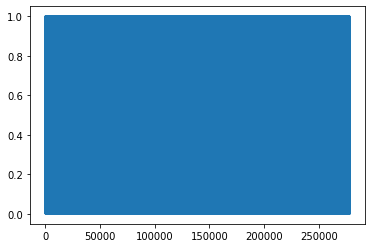

In [13]:
plt.plot(Cash_loans)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_stk_prices = scaler.fit_transform(Cash_loans)

In [14]:
train_size = int(len(Cash_loans) * 0.80)
test_size = len(Cash_loans) - train_size
train, test = Cash_loans[0:train_size,:], Cash_loans[train_size:len(Cash_loans),:]
print(len(train), len(test))

222585 55647


In [15]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# SOLVE USING RNN

In [18]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.011039018630981445


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [19]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    nb_epoch=10,
    validation_split=0.05)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 211453 samples, validate on 11130 samples
Epoch 1/10
211453/211453 [==============================] - 12s 56us/step - loss: 0.0768 - val_loss: 0.0770
Epoch 2/10
211453/211453 [==============================] - 10s 48us/step - loss: 0.0768 - val_loss: 0.0771
Epoch 3/10
211453/211453 [==============================] - 9s 44us/step - loss: 0.0768 - val_loss: 0.0771
Epoch 4/10
211453/211453 [==============================] - 9s 45us/step - loss: 0.0768 - val_loss: 0.0770
Epoch 5/10
211453/211453 [==============================] - 10s 48us/step - loss: 0.0768 - val_loss: 0.0770
Epoch 6/10
211453/211453 [==============================] - 9s 44us/step - loss: 0.0768 - val_loss: 0.0770
Epoch 7/10
211453/211453 [==============================] - 10s 45us/step - loss: 0.0768 - val_loss: 0.0771
Epoch 8/10
211453/211453 [==============================] - 11s 53us/step - loss: 0.0768 - val_loss: 0.0770
Epoch 9/10
211453/211453 [==============================] - 10s 47us/step - loss: 0.0767

In [24]:
score=model.evaluate(testX,testY)

55645/55645 [==============================] - 2s 40us/step


In [28]:
score

0.07547820648560895

In [ ]:
def plt_results_multiple(predicted_data, true_data,length):
    plt.plot(scaler.inverse_transform(true_data.reshape(-1, 1))[length:])
    plt.plot(scaler.inverse_transform(np.array(predicted_data).reshape(-1, 1))[length:])
    plt.show()
    
#predict length consecutive values from a real one
def predict_sequences_multiple(model, firstValue,length):
    prediction_seqs = []
    curr_frame = firstValue
    
    for i in range(length): 
        predicted = []        
        
        print(model.predict(curr_frame[newaxis,:,:]))
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        
        curr_frame = curr_frame[0:]
        curr_frame = np.insert(curr_frame[0:], i+1, predicted[-1], axis=0)
        
        prediction_seqs.append(predicted[-1])
        
    return prediction_seqs

predict_length=5
predictions = predict_sequences_multiple(model, testX[0], predict_length)
print(scaler.inverse_transform(np.array(predictions).reshape(-1, 1)))
plt_results_multiple(predictions, testY, predict_length)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# SOLVE USING ANN

In [ ]:
x.dtypes

In [ ]:
x=x.select_dtypes(exclude='object')
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.25,random_state=2)

In [ ]:
train_y=keras.utils.to_categorical(train_y)
test_y=keras.utils.to_categorical(test_y)

In [ ]:
#BUILD THE MODEL
model=Sequential()
model.add(Dense(1000,input_shape=(105,),activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()

In [ ]:
opt=SGD(lr=0.001,momentum=0.9)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
history=model.fit(train_x,train_y,
                 batch_size=2000,
                 epochs=20,
                 verbose=1,
                 validation_data=(test_x,test_y),
                 validation_freq=2)

In [ ]:
score=model.evaluate(test_x,test_y)

In [ ]:
print('test Loss : {}'.format(score[0]))
print('test Accuracy : {}'.format(score[1]))

In [7]:
ll *loan*

-rw-r--r--@ 1 pragyamohapatra  staff     355244 May 13 01:46 Housing_loan_1.html
-rw-r--r--@ 1 pragyamohapatra  staff  166133370 May 12 19:50 loan_data (1).csv
